In [2]:
#  ! pip install icevision

In [7]:
from icevision.all import *

/home/ubuntu/miniconda3/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(
INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/ubuntu/.icevision/mmdetection_configs/mmdetection_configs-2.10.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


# Configure the Train and Validation Datasets

In [10]:
# Location of the image root
# Update the path of the nikelogs
data_dir = Path('/home/ubuntu/nikelogos')
print(data_dir)
print(type(data_dir))

# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "annotations", images_dir=data_dir / "images")
parser.class_map


# Parse annotations to create records
train_records, valid_records = parser.parse()

# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize(), tfms.A.Rotate()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

len(train_ds), len(valid_ds)

/home/ubuntu/nikelogos
<class 'pathlib.PosixPath'>


INFO     - Autofixing records | icevision.parsers.parser:parse:136


WARNING  - (record_id: 250) - 🚫 Record could not be autofixed and will be removed because: File '/home/ubuntu/nikelogos/images/nike_logo_shoes_528.jpg' does not exist | icevision.core.record:autofix_records:100
WARNING  - (record_id: 340) - 🚫 Record could not be autofixed and will be removed because: File '/home/ubuntu/nikelogos/images/nike_logo_tshirt_362.jpg' does not exist | icevision.core.record:autofix_records:100


(406, 100)

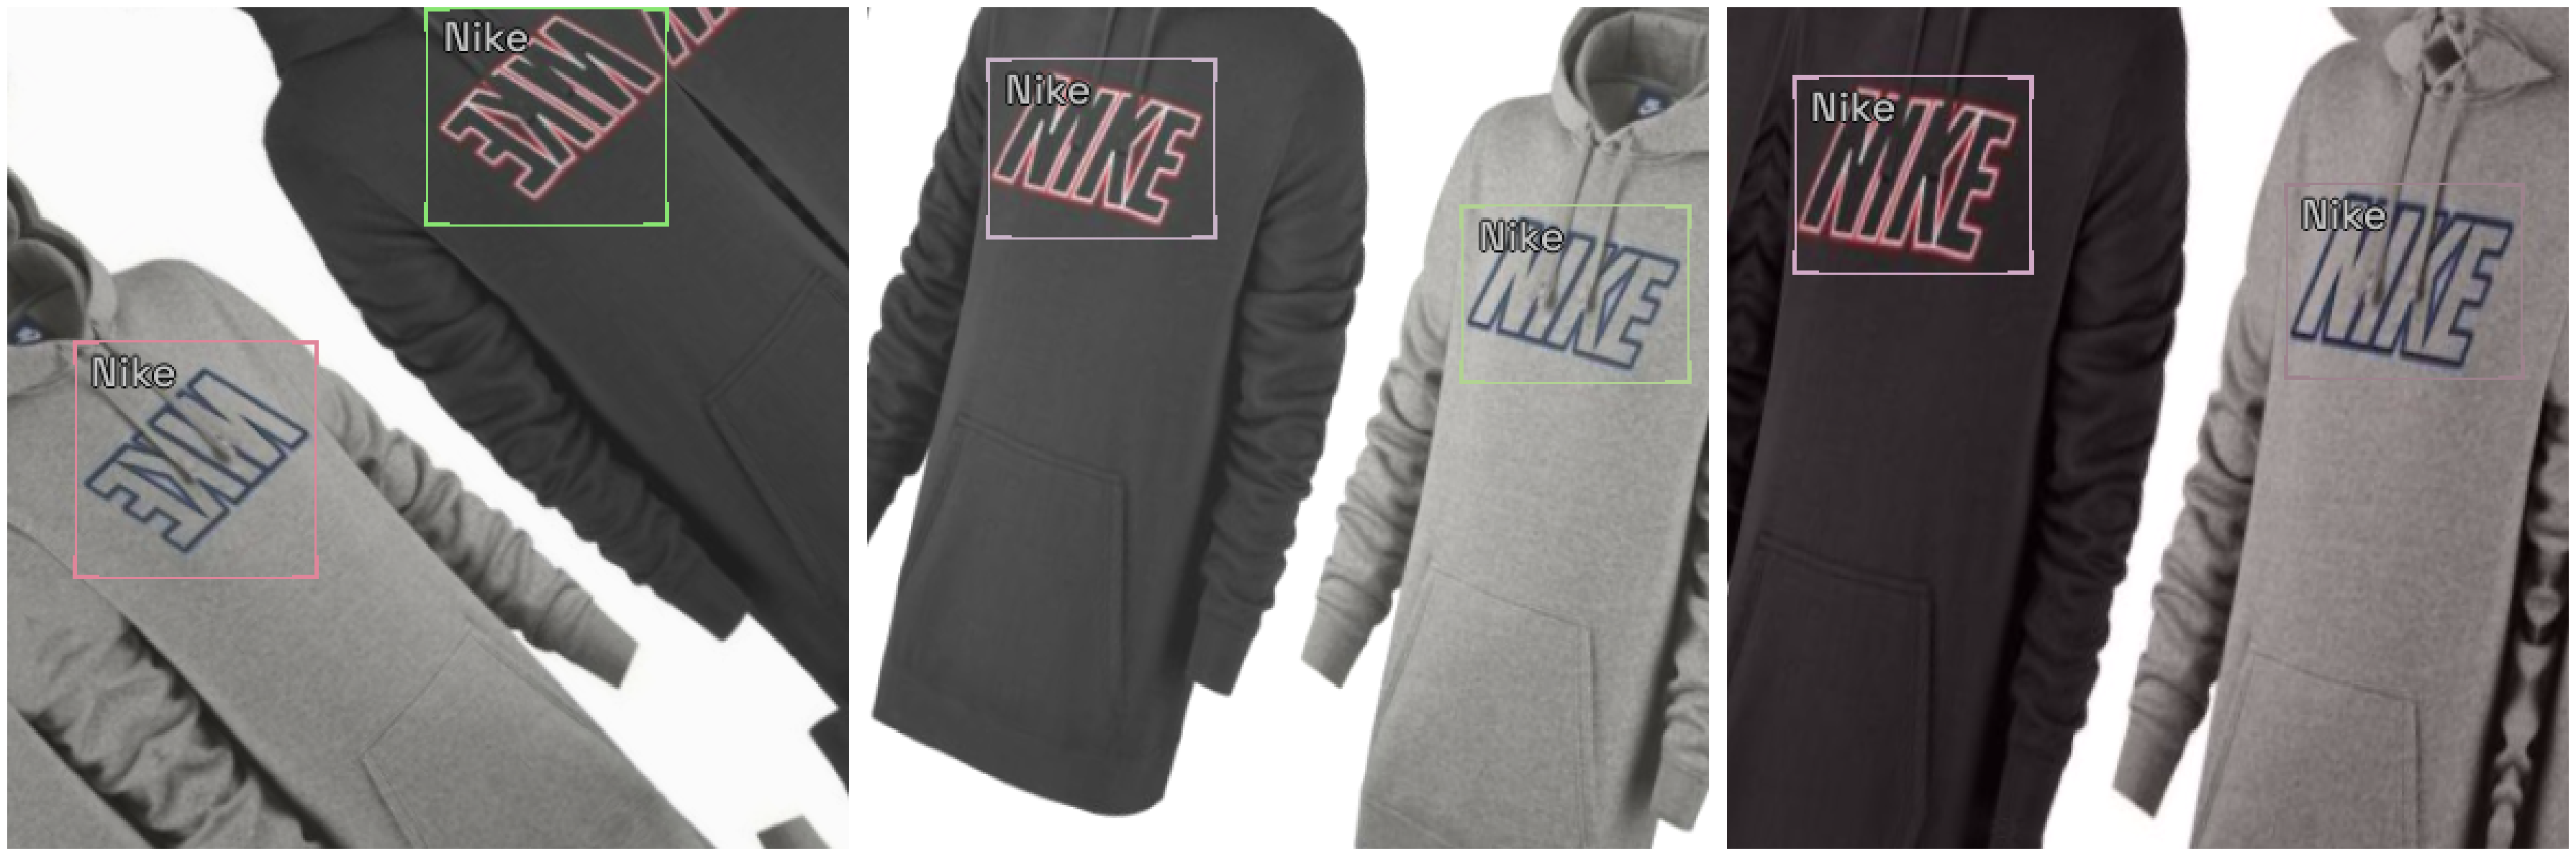

In [11]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

# Train Multiple Models
Train Multiple Models with different models types and epochs
Then output the data dictionary for later use

In [18]:
extra_args = {}

# We found that only models 1,2, and 3 worked with the single image predictions
for selection in [1,2,3]:
    if selection == 0:
      model_type = models.mmdet.retinanet
      backbone = model_type.backbones.resnet50_fpn_1x

    elif selection == 1:
      # The Retinanet model is also implemented in the torchvision library
      model_type = models.torchvision.retinanet
      backbone = model_type.backbones.resnet50_fpn

    elif selection == 2:
      model_type = models.ross.efficientdet
      backbone = model_type.backbones.tf_lite0
      # The efficientdet model requires an img_size parameter
      extra_args['img_size'] = image_size

    elif selection == 3:
      model_type = models.ultralytics.yolov5
      backbone = model_type.backbones.small
      # The yolov5 model requires an img_size parameter
      extra_args['img_size'] = image_size

    model_type, backbone, extra_args

    # Instantiate the mdoel
    model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

    # Data Loaders
    train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
    valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

    metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

    learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

    # For each model, train using different epoch values
    for num_epochs in [30,50,100]:
        learn.fine_tune(num_epochs, 1e-4, freeze_epochs=1)
        PATH = f"nikemodel_model_{selection}_new_{num_epochs}.mm"
        torch.save(model.state_dict(), PATH)

epoch,train_loss,valid_loss,COCOMetric,time
0,1.769948,1.655290,0.001436,00:16


epoch,train_loss,valid_loss,COCOMetric,time
0,1.368822,1.524597,0.005709,00:26
1,1.271823,1.466592,0.004842,00:26
2,1.254885,1.431082,0.006477,00:26
3,1.202683,1.333296,0.009806,00:26
4,1.175997,1.357984,0.012390,00:26
5,1.125208,1.237863,0.023189,00:26
6,1.078577,1.190360,0.041211,00:27
7,1.048605,1.234263,0.037499,00:26
8,1.027451,1.133883,0.061738,00:26
9,0.980035,1.064110,0.068257,00:27


epoch,train_loss,valid_loss,COCOMetric,time
0,0.720212,0.870681,0.135192,00:18


epoch,train_loss,valid_loss,COCOMetric,time
0,0.684293,0.798138,0.149558,00:27
1,0.666625,0.773847,0.165033,00:27
2,0.661030,0.797881,0.144490,00:27
3,0.667490,0.782451,0.169049,00:27
4,0.666535,0.798663,0.172002,00:27
5,0.665347,0.795963,0.170214,00:27
6,0.655787,0.796971,0.160650,00:27
7,0.659275,0.782218,0.185085,00:27
8,0.656616,0.785668,0.173086,00:27
9,0.652125,0.808158,0.148384,00:27


epoch,train_loss,valid_loss,COCOMetric,time
0,0.481132,0.692810,0.236431,00:18


epoch,train_loss,valid_loss,COCOMetric,time
0,0.492829,0.645618,0.258601,00:27
1,0.474980,0.654418,0.262553,00:27
2,0.470123,0.647539,0.254995,00:27
3,0.456526,0.676323,0.255377,00:27
4,0.468404,0.660603,0.263901,00:27
5,0.453594,0.632897,0.271196,00:27
6,0.449910,0.677082,0.261870,00:27
7,0.451638,0.690002,0.256097,00:27
8,0.469327,0.681469,0.247843,00:27
9,0.460197,0.643085,0.268586,00:27


epoch,train_loss,valid_loss,COCOMetric,time
0,2.213436,1.470451,0.000928,00:11


epoch,train_loss,valid_loss,COCOMetric,time
0,1.901787,1.455801,0.000859,00:12
1,1.843294,1.652691,0.000951,00:12
2,1.776696,1.505061,0.001513,00:12
3,1.742226,1.580975,0.001774,00:12
4,1.689360,2.137031,0.002507,00:12
5,1.663641,2.856068,0.003264,00:12
6,1.631462,1.611799,0.006570,00:12
7,1.583658,2.392126,0.010488,00:12
8,1.549276,1.345510,0.024898,00:12
9,1.521879,1.862492,0.030877,00:12


epoch,train_loss,valid_loss,COCOMetric,time
0,1.253756,1.035286,0.153015,00:10


epoch,train_loss,valid_loss,COCOMetric,time
0,1.215598,1.295840,0.057399,00:12
1,1.197937,1.228592,0.063340,00:12
2,1.205246,1.023647,0.167060,00:12
3,1.201844,1.777639,0.046080,00:12
4,1.200224,1.076585,0.111680,00:12
5,1.183751,1.055232,0.118494,00:12
6,1.198997,1.737396,0.045049,00:12
7,1.182489,1.331746,0.060151,00:12
8,1.159784,1.157626,0.076966,00:12
9,1.170539,1.502593,0.061363,00:12


epoch,train_loss,valid_loss,COCOMetric,time
0,0.925395,0.853602,0.146333,00:10


epoch,train_loss,valid_loss,COCOMetric,time
0,0.880793,1.205953,0.065980,00:12
1,0.892179,0.791311,0.191416,00:12
2,0.882539,0.859873,0.145330,00:12
3,0.893192,1.033784,0.075886,00:12
4,0.880303,0.847079,0.142893,00:12
5,0.902297,0.941276,0.100742,00:12
6,0.879760,0.776277,0.189877,00:12
7,0.894787,0.947183,0.103355,00:12
8,0.870653,0.871312,0.137679,00:12
9,0.874560,0.760610,0.203293,00:12


epoch,train_loss,valid_loss,COCOMetric,time
0,0.665671,0.638442,0.000830,00:06


epoch,train_loss,valid_loss,COCOMetric,time
0,0.637540,0.628966,0.000975,00:07
1,0.639408,0.619204,0.001152,00:07
2,0.622633,0.605683,0.002745,00:07
3,0.615748,0.590311,0.005371,00:07
4,0.596098,0.571345,0.021170,00:07
5,0.582530,0.552966,0.049055,00:07
6,0.567872,0.538230,0.064519,00:07
7,0.553354,0.520131,0.071272,00:07
8,0.542272,0.503849,0.081584,00:07
9,0.520589,0.492918,0.083310,00:07


epoch,train_loss,valid_loss,COCOMetric,time
0,0.441231,0.408277,0.160959,00:06


epoch,train_loss,valid_loss,COCOMetric,time
0,0.441255,0.408019,0.147574,00:07
1,0.428655,0.406719,0.148859,00:07
2,0.426736,0.405310,0.143924,00:07
3,0.431528,0.402024,0.159429,00:07
4,0.436866,0.402025,0.137964,00:07
5,0.435286,0.399349,0.161808,00:07
6,0.437458,0.397490,0.151568,00:07
7,0.425444,0.393800,0.169436,00:07
8,0.421566,0.390650,0.163327,00:07
9,0.412803,0.386661,0.174276,00:07


epoch,train_loss,valid_loss,COCOMetric,time
0,0.352956,0.319587,0.254130,00:06


epoch,train_loss,valid_loss,COCOMetric,time
0,0.365637,0.318910,0.251128,00:07
1,0.367923,0.318554,0.252186,00:07
2,0.361190,0.316275,0.273356,00:07
3,0.352775,0.314472,0.281888,00:07
4,0.351308,0.317106,0.249999,00:07
5,0.350251,0.314845,0.264137,00:07
6,0.350254,0.315537,0.251237,00:07
7,0.344204,0.314372,0.267525,00:07
8,0.353327,0.313760,0.257473,00:07
9,0.352034,0.312180,0.267082,00:07
